## Simulador de Recorridos ciclistas

### Importamos librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle
import time

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Como tenemos procesado todo en el mismo fichero, lo cargamos

#path = '../Entrenamientos/Procesado_Tramos.xlsx'
path = '../Entrenamientos/Procesado_Tramos_simulacion.xlsx'
df = pd.read_excel(path)

### Filtramos datos

In [3]:
#Eliminar las filas que no tienen datos y seleccionamos la prueba que queremos simular
df = df[df["porc"]!=np.inf]
#df = df[df["prueba"]=="20180429_LEMG_195_90_R_C.gpx"]

In [4]:
df.describe()

,tramo,tramo_inicial,tramo_final,dist,viento_aparente,porc,dist_acum
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,41.500000,1220.797619,1252.880952,507.744281,-0.587996,-0.047731,19509.435551
std,24.392622,777.046195,781.656619,693.744429,5.336408,1.819731,12154.558566
min,0.000000,0.000000,25.000000,12.158278,-9.954147,-4.645913,329.544198
25%,20.750000,529.750000,609.500000,25.516494,-4.099877,-0.565377,9742.611994
50%,41.500000,1235.500000,1266.000000,145.726222,-1.248373,0.001432,19614.673821
75%,62.250000,1779.000000,1797.500000,784.964079,2.888754,0.363841,27829.260059
max,83.000000,2663.000000,2695.000000,3454.663686,9.997376,4.950157,42624.028333


In [5]:
#Se revisa que no existan datos anómalos
df.head()

,tramo,tramo_inicial,tramo_final,dist,viento_aparente,porc,dist_acum,prueba
0,0,0,25,344.041550,3.492273,1.596116,329.544198,xxxxxxxx_LEVS_195_90_R_E.gpx
1,1,25,26,13.567297,1.574548,-0.218832,344.041550,xxxxxxxx_LEVS_195_90_R_E.gpx
2,2,26,37,168.993513,1.731397,0.371159,509.985494,xxxxxxxx_LEVS_195_90_R_E.gpx
3,3,37,38,17.331806,1.575208,-0.067596,526.602360,xxxxxxxx_LEVS_195_90_R_E.gpx
4,4,38,41,48.498332,3.407638,0.074144,579.260182,xxxxxxxx_LEVS_195_90_R_E.gpx


(array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 1., 1., 4., 5., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 3., 6., 7., 6., 7., 4.,
        5., 3., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        2., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
        1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-4.64591325, -4.54995255, -4.45399185, -4.35803115, -4.26207045,
        -4.16610974, -4.07014904, -3.97418834, -3.87822764, -3.78226694,
        -3.68630624, -3.59034553, -3.49438483, -3.39842413, -3.30246343,
        -3.20650273, -3.11054202, -3.01458132, -2.91862062, -2.82265992,
        -2.72669922, -2.63073852, -2.53477781, -2.43881711, -2.34285641,
        -2.24689571, -2.15093501, -2.05497431, -1.9590136 , -1.8630529 ,
        -1.7670922 , -1.6711315 , -1.5751708 , -1.4792101 , -1.38324939,
        -1.28728869, -1.19132799, -1.09

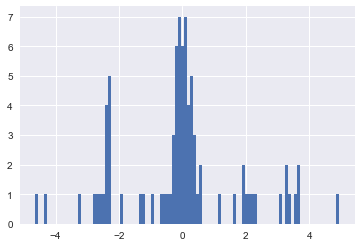

In [6]:
plt.hist(df['porc'],bins=100)

Vemos que la mayoría de tramos están centrados en porcentajes cercanos a 0, aunque también hay varios tramos de subidas y bajadas

In [12]:
#Prueba iterando en cada tramo con intervalos aleatorios con el modelo desarrollado CON TENSORFLOW (PRIMERA PASADA)

#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 220
pot_min = 80
pot_max = 280
ff_1 = 0.4
ff_2 = 0.6

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d, llevamos %d exitos y %d fracasos' %(fi,exito,fail))
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    bins_potencias = [0] * 30
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
   
    
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/2)-1
            max_random = abs(viento**2)+1
        else:
            max_random = (viento/2)+1
            min_random = (-1*viento**2)-1
            
        potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))*(np.random.randint(min_random,max_random)+100)/100
        #potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-100,100)
        potencia_min = pot_min+(pot_max-25-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
        potencia_max = pot_min+25+(pot_max-pot_min-25)/(1+ff_1*np.e**(ff_2*porc*-1))
                                            
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
        
        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        #acumulamos el tiempo que se pasa en cada agrupacion de potencias
        bins_potencias[int(potencia/10)] =bins_potencias[int(potencia/10)] + nuevo_tiempo[0]
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d y tiempo %d" %(fi, potencia_media, tiempo_acum))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-5) and (potencia_media < potencia_objetivo+5):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

Empezamos la prueba 0, llevamos 0 exitos y 0 fracasos
--- 0.6902143955230713 seconds ---
Intento 0 con potencia media 222 y tiempo 4962
Intento 1 con potencia media 222 y tiempo 4954
Intento 2 con potencia media 221 y tiempo 4973
Intento 3 con potencia media 222 y tiempo 4963
Intento 4 con potencia media 222 y tiempo 4960
Intento 5 con potencia media 221 y tiempo 4971
Intento 6 con potencia media 222 y tiempo 4961
Intento 7 con potencia media 221 y tiempo 4967
Intento 8 con potencia media 221 y tiempo 4967
Intento 9 con potencia media 221 y tiempo 4968
Empezamos la prueba 10, llevamos 10 exitos y 0 fracasos
--- 2.197462320327759 seconds ---
Intento 10 con potencia media 221 y tiempo 4970
Intento 11 con potencia media 221 y tiempo 4965
Intento 12 con potencia media 221 y tiempo 4967
Intento 13 con potencia media 221 y tiempo 4967
Intento 14 con potencia media 220 y tiempo 4975
Intento 15 con potencia media 221 y tiempo 4970
Intento 16 con potencia media 220 y tiempo 4971
Intento 17 con 

In [21]:
histo_pot = pd.DataFrame(bins_potencias)
histo_pot[potencia]=histo_pot.index.values*10
histo_pot.columns = ['segundos','potencia']
histo_pot

,segundos,potencia
0,0.000000,0
1,0.000000,10
2,0.000000,20
3,0.000000,30
4,0.000000,40
5,0.000000,50
6,0.000000,60
7,0.000000,70
8,0.000000,80
9,0.000000,90


In [27]:
sum(bins_potencias[-5:])

2494.641181945801

In [ ]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

In [ ]:
plt.scatter(ds['pwr'],ds['secs'])

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

In [ ]:
plt.hist(ds['pwr'],bins=50)

Histograma de potencias validas para la simulación

In [ ]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

In [ ]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']<=a[:50].max()][['intento','list']])
ganadores

In [ ]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

In [ ]:
df_ganador.describe()

In [ ]:
plt.hist(df_ganador['Potencia'])

In [ ]:
plt.scatter(df_ganador['Pendiente'],df_ganador['Potencia'])

La distribución de potencia es acorde a lo esperado

In [ ]:
#Juntamos el resultado de la simulación con el recorrido original a efectos de comparativa posterior en Tableau
df_input = df[['tramo','pwr','spd','dist','time_seg','porc','viento_aparente']]
df_input.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
df_input['Intento'] = 'Original'
df_input.append([df_ganador]).to_excel('res_sim_ori.xlsx')
df_input.head()

In [ ]:
potencias_medias = df_ganador.groupby(['Tramos'])['Potencia'].agg('median')

#### Posible mejora del modelo, inicializando la potencia de cada tramo con el mejor resultado de la primera simulación

In [ ]:
#CON TENSORFLOW (SEGUNDA PASADA)
#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 220
pot_min = 60
pot_max = 275
ff_1 = 0.3
ff_2 = 0.7

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/2)-1
            max_random = abs(viento*2)+1
        else:
            max_random = (viento/2)+1
            min_random = (-1*viento*2)-1
                
        potencia_aux = potencias_medias[i]*(np.random.randint(min_random,max_random)+100)/100
        potencia_min = pot_min+(pot_max-30-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
        potencia_max = pot_min+30+(pot_max-pot_min-30)/(1+ff_1*np.e**(ff_2*porc*-1))
                                            
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
    
        
        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-5) and (potencia_media < potencia_objetivo+5):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

In [ ]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

In [ ]:
plt.scatter(ds['pwr'],ds['secs'])

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

In [ ]:
plt.hist(ds['pwr'],bins=50)

Histograma de potencias validas para la simulación

In [ ]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

In [ ]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']<=a[:50].max()][['intento','list']])
ganadores

In [ ]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

In [ ]:
df_ganador.describe()

In [ ]:
plt.hist(df_ganador['Potencia'])

In [ ]:
plt.scatter(df_ganador['Pendiente'],df_ganador['Potencia'])